In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot

In [13]:
plates = ['20211209','20220401','20220812']

In [14]:
metadata = pd.read_csv('HB_annotation.csv')
metadata['Plate'] = metadata['Plate'].astype(str)

In [15]:
dfs = []
for plate in plates:
    df_nuc = pd.read_csv(Path(plate) / 'analyse/Nuclei.csv')
    df_nuc = df_nuc.drop([x for x in df_nuc.columns if 'Location' in x], axis=1)
    cols = df_nuc.columns[np.where(df_nuc.columns.values=='AreaShape_Area')[0][0]:]
    recols = {}
    for col in cols:
        recols[col] = 'Nuclei_'+col
    df_nuc = df_nuc.rename(recols, axis=1)
    df_cell = pd.read_csv(Path(plate) / 'analyse/Cells.csv' )
    df_cell = df_cell.drop([x for x in df_cell.columns if 'Metadata' in x or 'Location' in x], axis=1)
    cols = df_cell.columns[np.where(df_cell.columns.values=='AreaShape_Area')[0][0]:]
    recols = {}
    for col in cols:
        recols[col] = 'Cell_'+col
    df_cell = df_cell.rename(recols, axis=1)
    df = pd.concat([df_nuc,df_cell], axis=1)
    df['Plate'] = plate
    dfs.append(df)
df = pd.concat(dfs, axis=0).reset_index(drop=True)

In [16]:
df = df.merge(metadata, left_on=['Plate','Metadata_Well'], right_on=['Plate','Well'], how='left')
featcols = [x for x in df.columns.tolist() if 'AreaShape' in x or 'Intensity' in x or 'Texture' in x]
for col in ['Nuclei_AreaShape_Center_Z','Cell_AreaShape_Center_X','Cell_AreaShape_Center_Y','Cell_AreaShape_Center_Z']:
    featcols.remove(col)
metacols = metadata.columns.tolist()+['ObjectNumber']
df = df[metacols+featcols]

In [17]:
# Normalize based on DMSO
coords = df[['Nuclei_AreaShape_Center_X','Nuclei_AreaShape_Center_Y']].copy()
for i,row in df[['Plate','Cell line']].drop_duplicates().iterrows():
    df_sel = df[(df['Plate']==row['Plate'])&(df['Cell line']==row['Cell line'])]
    df_ctrl = df_sel[df_sel['Treatment']=='DMSO']
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(df_ctrl[featcols])
    df.loc[df_sel.index,featcols] = scaler.transform(df_sel.loc[:,featcols])
df.loc[:,coords.columns] = coords

In [18]:
# Normalize mean based on DMSO
df_mean = df.groupby(['Cell line','Plate','Treatment','Concentration']).mean().reset_index()
for i,row in df_mean[['Plate','Cell line']].drop_duplicates().iterrows():
    df_sel = df_mean[(df_mean['Plate']==row['Plate'])&(df_mean['Cell line']==row['Cell line'])]
    df_ctrl = df_sel[df_sel['Treatment']=='DMSO']
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(df_ctrl[featcols])
    df_mean.loc[df_sel.index,featcols] = scaler.transform(df_sel.loc[:,featcols])

In [21]:
# Remove unneeded features
featcols.remove('Nuclei_AreaShape_Center_X')
featcols.remove('Nuclei_AreaShape_Center_Y')
featcols.remove('Nuclei_AreaShape_EulerNumber')

In [23]:
embeddings = []
for cline in df['Cell line'].drop_duplicates():
    mapper = umap.UMAP()
    df_cline = df[df['Cell line']==cline]
    # Drop Filanesib 0.1
    df_cline = df_cline.drop(df_cline[(df_cline['Treatment']=='Filanesib')&(df_cline['Concentration']==0.1)].index)
    mapper.fit(df_cline[featcols])
    embeddings.append((mapper,df_cline[['Cell line','Treatment','Concentration']]))

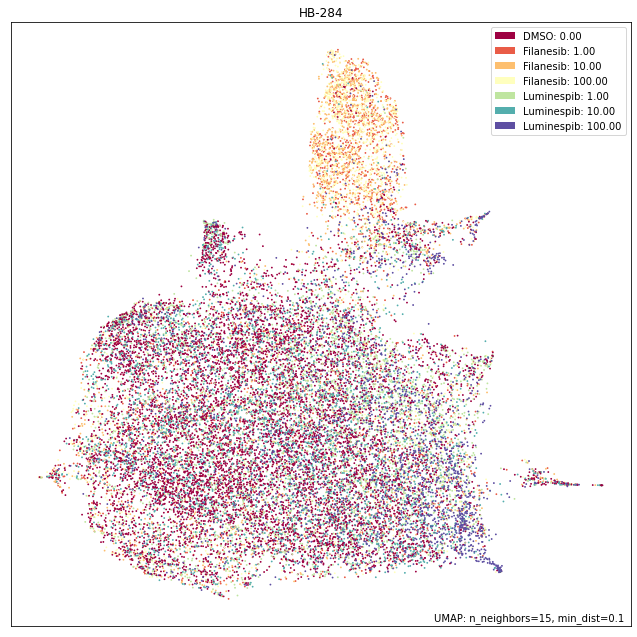

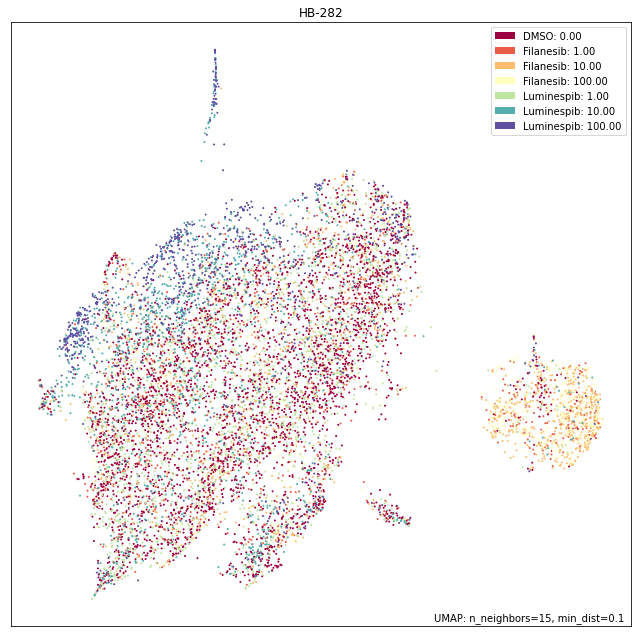

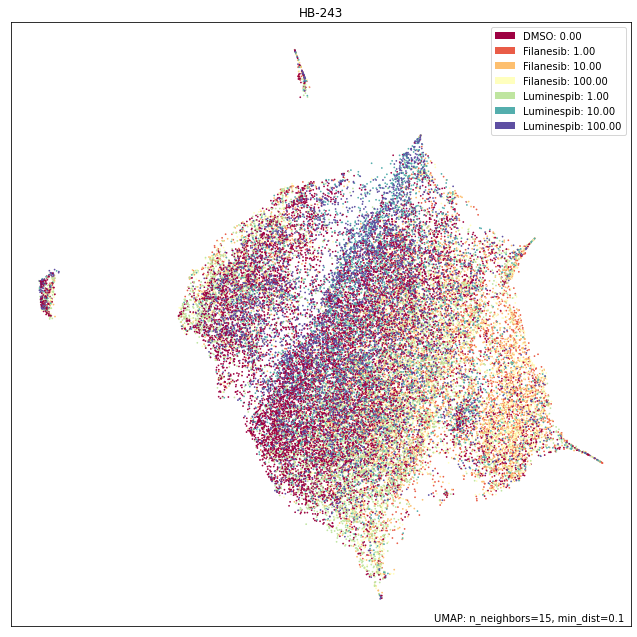

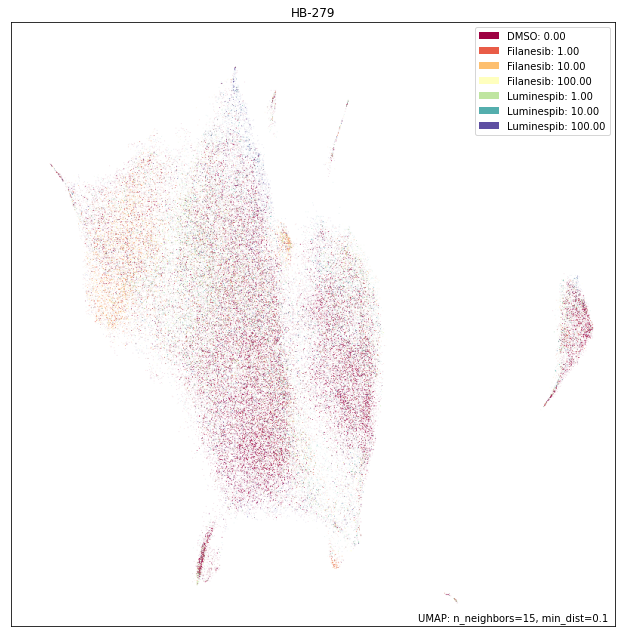

In [24]:
for mapper,df_cline in embeddings:
    df_cline['labels'] = [row['Treatment']+": {:.2f}".format(row['Concentration']) for i,row in df_cline.iterrows()]
    ax = umap.plot.points(mapper, labels=df_cline['labels'])
    ax.set_title(df_cline.iloc[0,0])
    #ax.get_figure().savefig("UMAP_"+df_cline.iloc[0,0]+".png")

In [25]:
embeddings_fila = []
for cline in df['Cell line'].drop_duplicates():
    mapper = umap.UMAP()
    df_cline = df[df['Cell line']==cline]
    # Drop Filanesib 0.1
    df_cline = df_cline.drop(df_cline[(df_cline['Treatment']=='Filanesib')&(df_cline['Concentration']==0.1)].index)
    # Drop Luminespib
    df_cline = df_cline.drop(df_cline[df_cline['Treatment']=='Luminespib'].index)
    mapper.fit(df_cline[featcols])
    embeddings_fila.append((mapper,df_cline[['Cell line','Treatment','Concentration']]))
    
embeddings_lumi = []
for cline in df['Cell line'].drop_duplicates():
    mapper = umap.UMAP()
    df_cline = df[df['Cell line']==cline]
    # Drop Filanesib
    df_cline = df_cline.drop(df_cline[df_cline['Treatment']=='Filanesib'].index)
    mapper.fit(df_cline[featcols])
    embeddings_lumi.append((mapper,df_cline[['Cell line','Treatment','Concentration']]))

In [30]:
for mapper,df_cline in embeddings_fila:
    print("{} cells: {:d}".format(df_cline.iloc[0,0],mapper.embedding_.shape[0]))

HB-284 cells: 14520
HB-282 cells: 6760
HB-243 cells: 22673
HB-279 cells: 54735


In [31]:
for mapper,df_cline in embeddings_lumi:
    print("{} cells: {:d}".format(df_cline.iloc[0,0],mapper.embedding_.shape[0]))

HB-284 cells: 18003
HB-282 cells: 7236
HB-243 cells: 24635
HB-279 cells: 67115


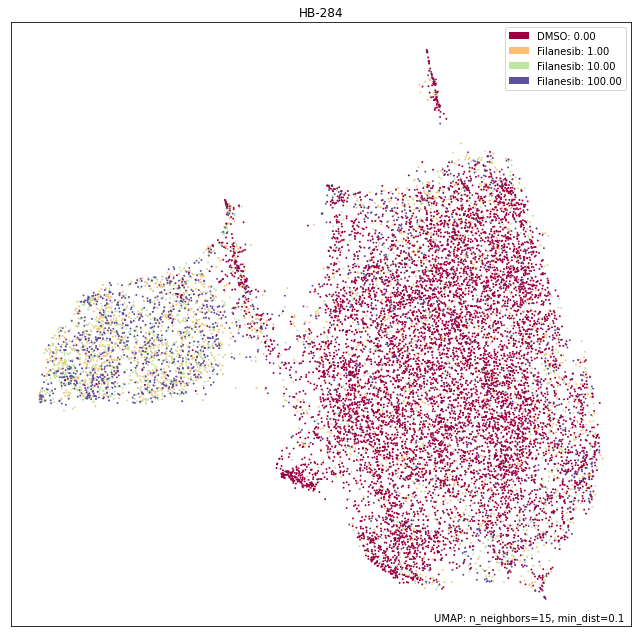

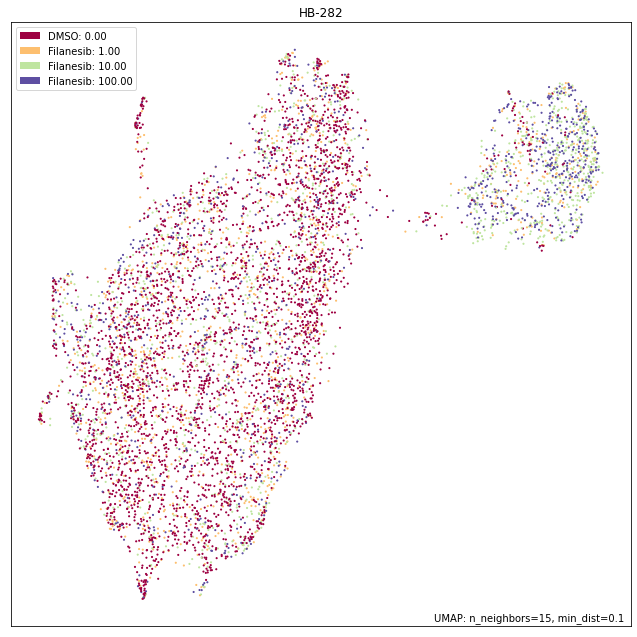

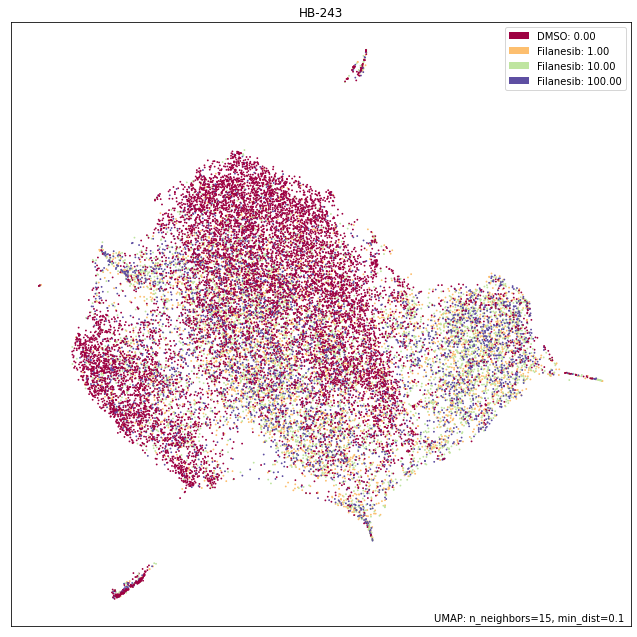

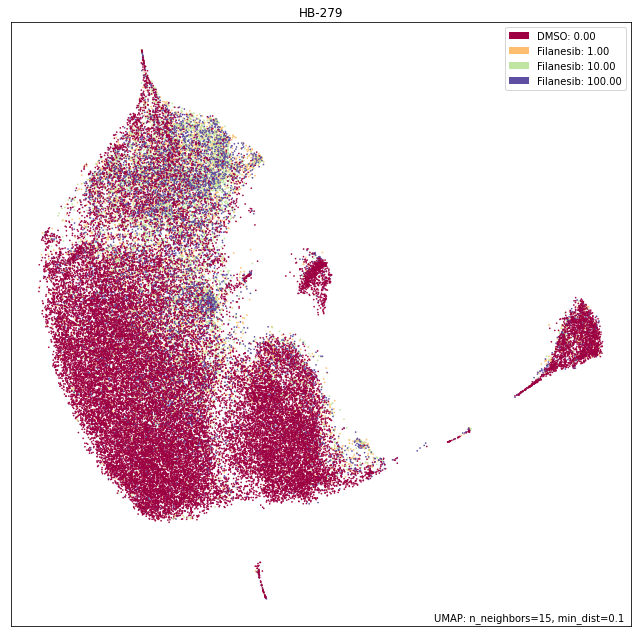

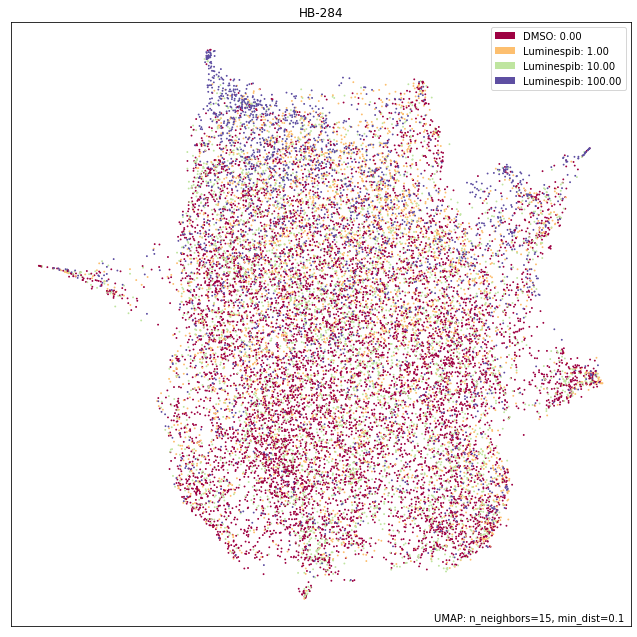

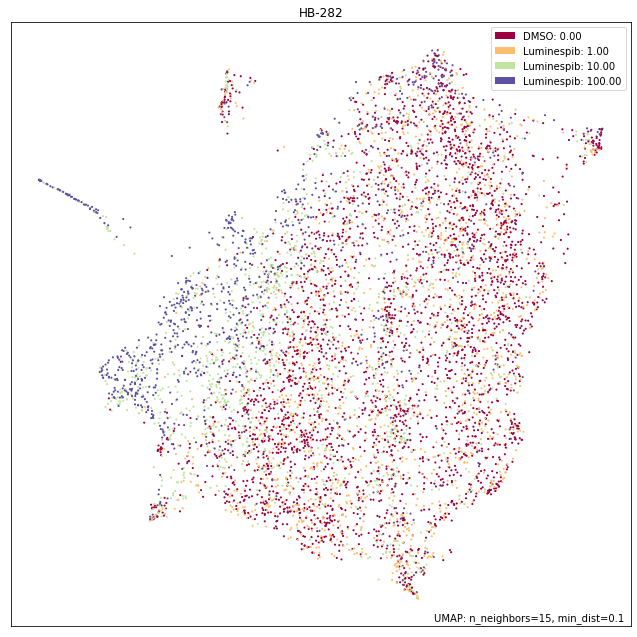

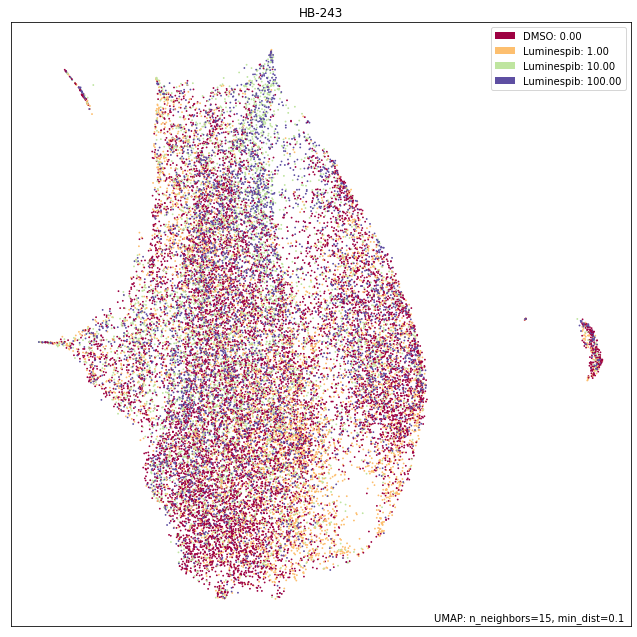

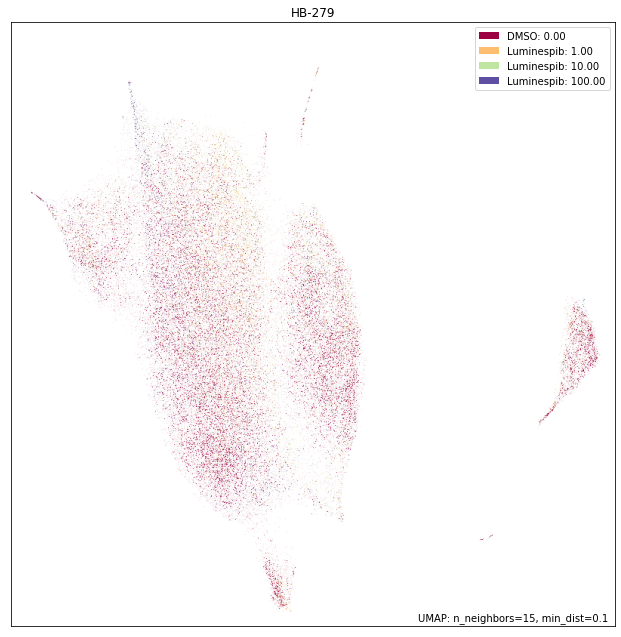

In [27]:
# The same plots separately for filanesib and luminespib
# Filanesib
for mapper,df_cline in embeddings_fila:
    df_cline['labels'] = [row['Treatment']+": {:.2f}".format(row['Concentration']) for i,row in df_cline.iterrows()]
    ax = umap.plot.points(mapper, labels=df_cline['labels'])
    ax.set_title(df_cline.iloc[0,0])
    ax.get_figure().savefig("UMAP_"+df_cline.iloc[0,0]+"_Filanesib.png")

# Luminespib
for mapper, df_cline in embeddings_lumi:
    df_cline['labels'] = [row['Treatment']+": {:.2f}".format(row['Concentration']) for i,row in df_cline.iterrows()]
    ax = umap.plot.points(mapper, labels=df_cline['labels'])
    ax.set_title(df_cline.iloc[0,0])
    ax.get_figure().savefig("UMAP_"+df_cline.iloc[0,0]+"_Luminespib.png")

<AxesSubplot:>

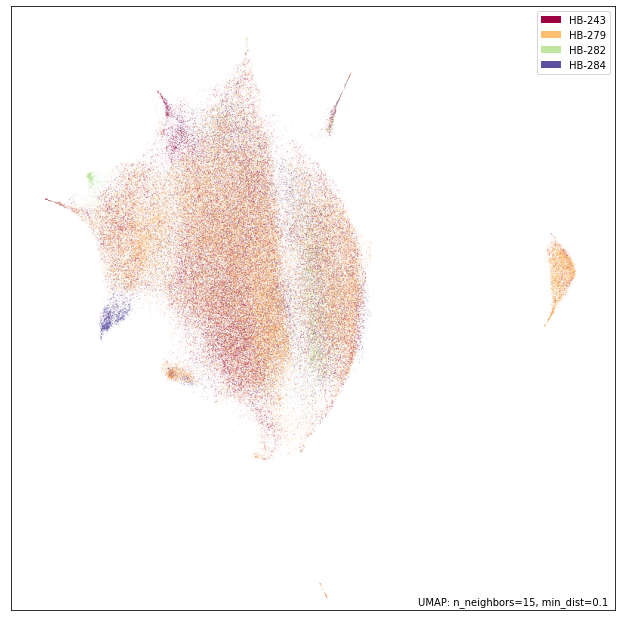

In [11]:
mapper = umap.UMAP()
mapper.fit(df[featcols])
umap.plot.points(mapper, labels=df['Cell line'])

In [12]:
# Test UMAP embedding for each treatment in different cell lines
embeddings = []
for treat,conc in [('Filanesib',1.0),('Filanesib',10.0),('Filanesib',100.0),('Luminespib',1.0),('Luminespib',10.0),('Luminespib',100.0)]:
    df_treat = df[(df['Treatment']==treat)&(df['Concentration']==conc)].copy()
    feat = df_treat[featcols]
    mapper = umap.UMAP()
    mapper.fit(feat)
    embeddings.append((df_treat,mapper))

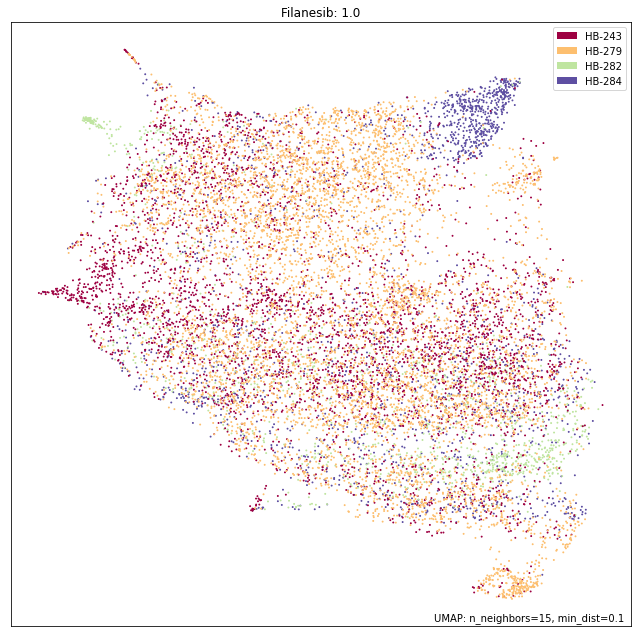

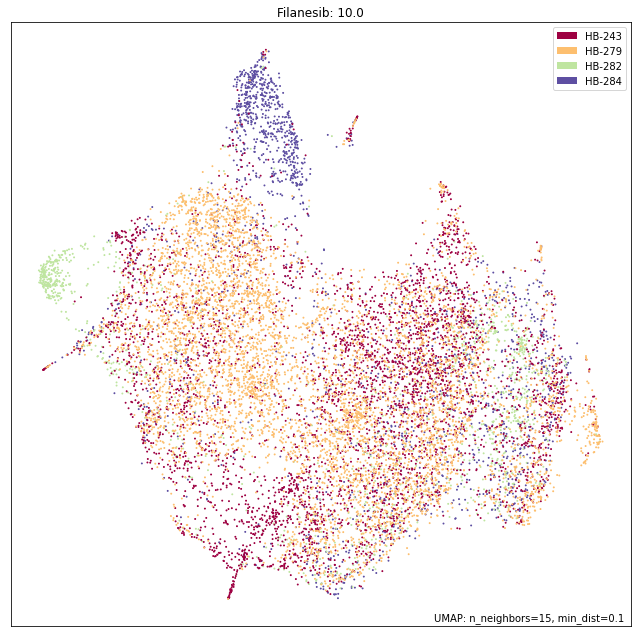

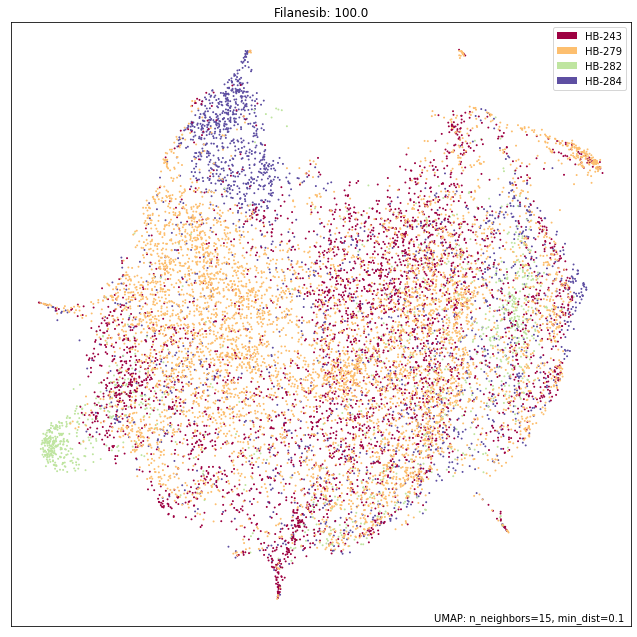

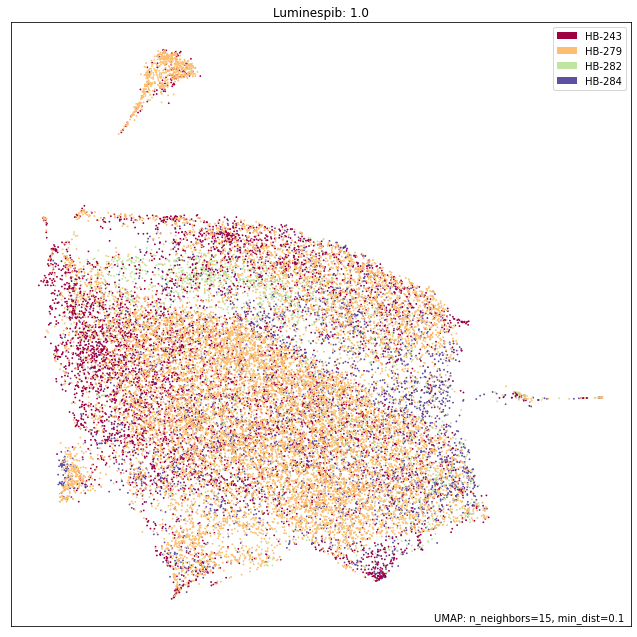

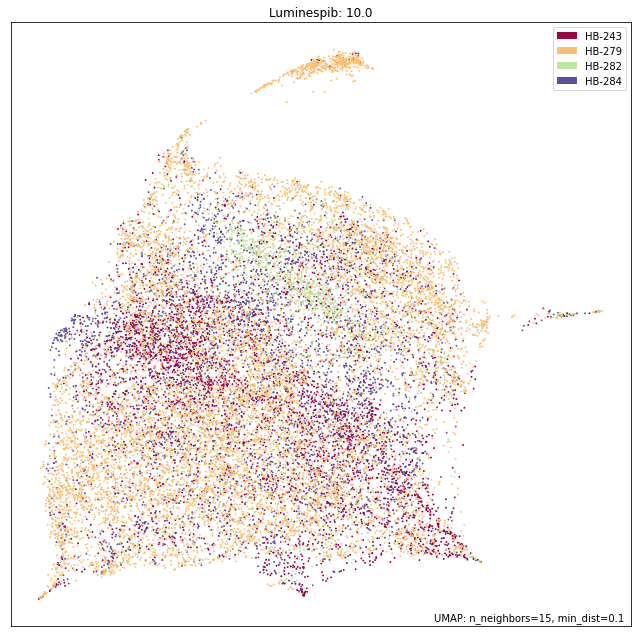

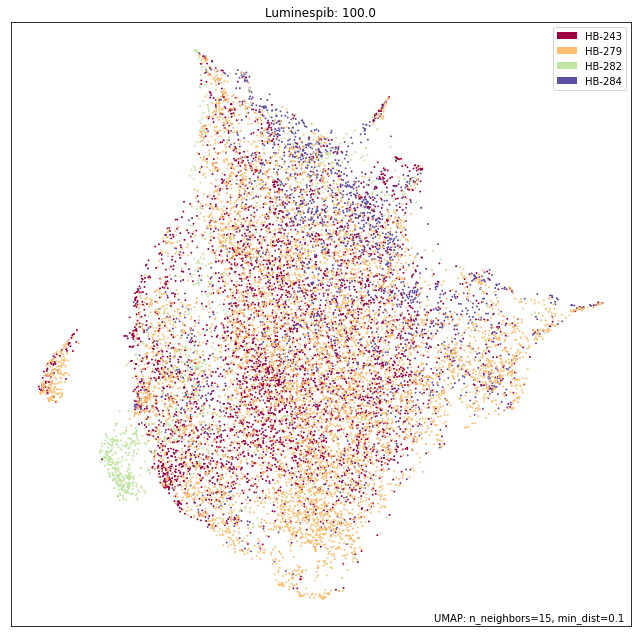

In [13]:
for df_treat,mapper in embeddings:
    ax = umap.plot.points(mapper, labels=df_treat['Cell line'])
    ax.set_title(df_treat.iloc[0,3] + ": " + df_treat.iloc[0,4].astype(str))
    ax.get_figure().savefig("UMAP_"+df_treat.iloc[0,3]+"_"+df_treat.iloc[0,4].astype(str)+".png")

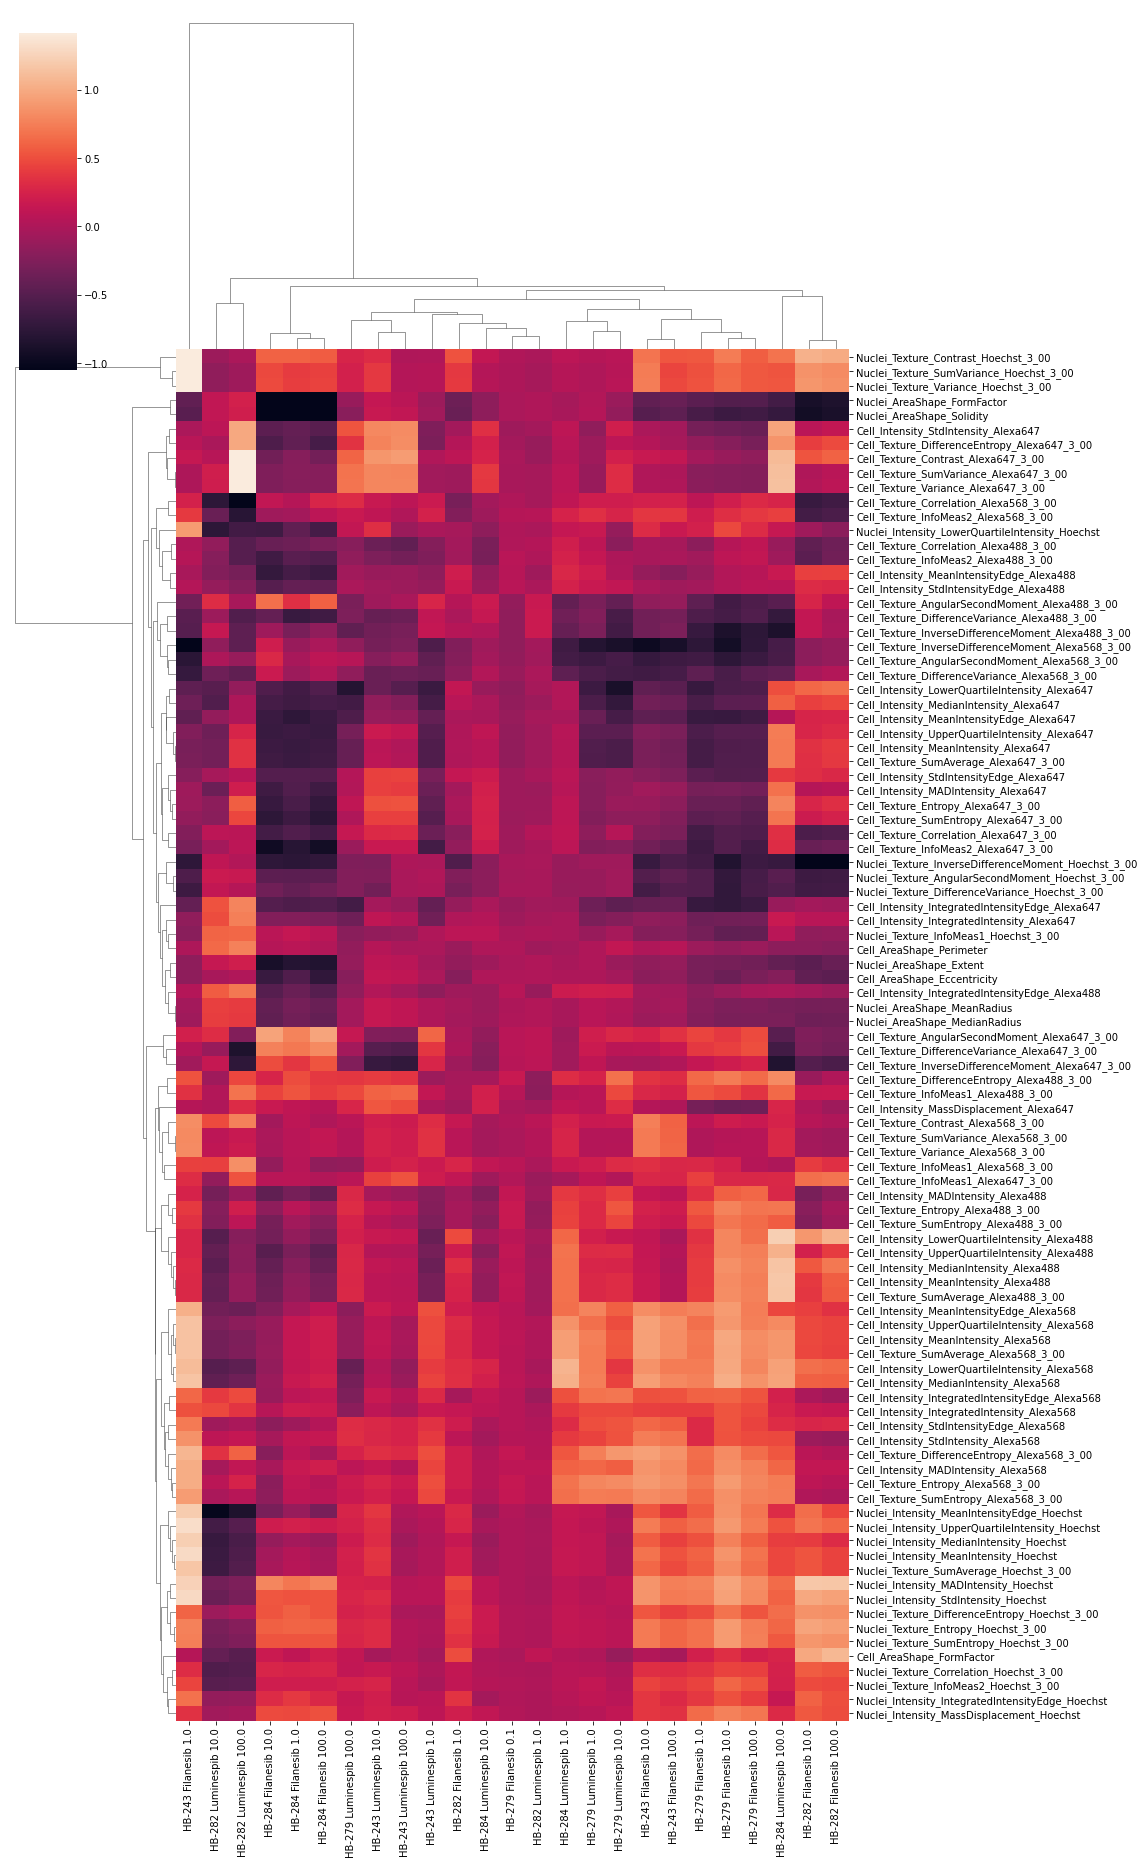

In [43]:
df_sns = df_mean.copy()
df_sns = df_sns[df_sns['Treatment']!='DMSO']
# Drop cols without variation
filtfeatcols = np.array(featcols)[np.where(df_sns[featcols].std()>0.20)[0]]
# Remove Texture directions 01, 02 and 03
filtfeatcols = [x for x in filtfeatcols if ('_3_01' not in x) and ('_3_02' not in x) and ('_3_03' not in x)]
filtfeatcols = [x for x in filtfeatcols if ('MinIntensity' not in x) and ('MaxIntensity' not in x)]
vmin = np.quantile(df_sns[filtfeatcols].min(axis=0), 0.05)
vmax = np.quantile(df_sns[filtfeatcols].max(axis=0), 0.95)
df_sns.index = df_sns['Cell line'] + ' ' + df_sns['Treatment'] + ' ' + df_sns['Concentration'].astype(str)
sns.clustermap(df_sns[filtfeatcols].transpose(), vmin=vmin, vmax=vmax, figsize=(16,26))
plt.savefig('heatmap_all.png', bbox_inches='tight')

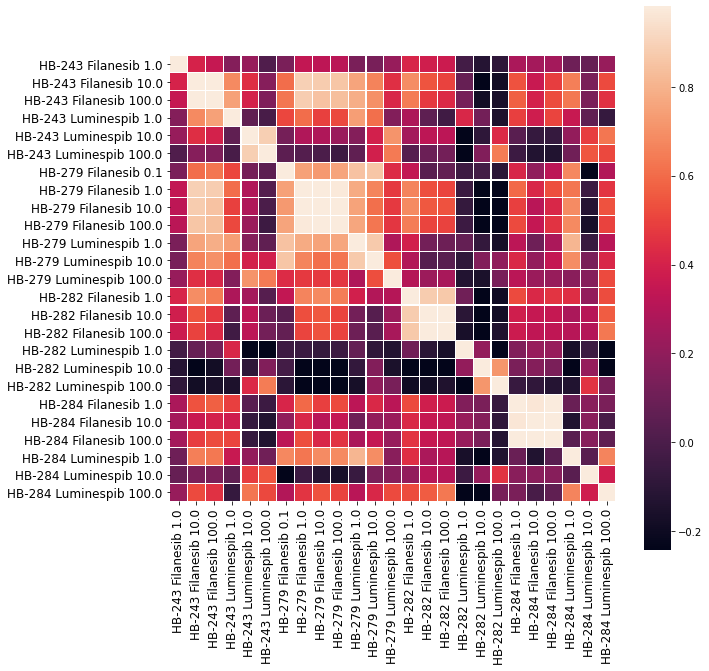

In [15]:
df_sns = df_mean.copy()
df_sns = df_sns[df_sns['Treatment']!='DMSO']
df_sns.index = df_sns['Cell line'] + ' ' + df_sns['Treatment'] + ' ' + df_sns['Concentration'].astype(str)
corr = df_sns[filtfeatcols].transpose().corr()
vmin = np.quantile(corr, 0.05)
vmax = np.quantile(corr, 0.95)
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=vmin, vmax=vmax, square=True, linewidths=.1, ax=ax)
ax.tick_params(labelsize=12)
plt.savefig("correlation.png", bbox_inches = "tight", dpi=300)

## Cell cycle stage

In [160]:
cycle_cols = [x for x in df.columns if 'Nuclei' in x]
cycle_cols.remove('Nuclei_AreaShape_Center_X')
cycle_cols.remove('Nuclei_AreaShape_Center_Y')

In [172]:
df['Cell line'].drop_duplicates()

0        HB-284
3414     HB-282
34742    HB-243
71189    HB-279
Name: Cell line, dtype: object

In [206]:
ccl = 'HB-279'
df_cycle = df[df['Treatment']=='DMSO'].reset_index(drop=True)
df_cycle = df_cycle[df_cycle['Cell line']==ccl]

<AxesSubplot:xlabel='Nuclei_AreaShape_Area', ylabel='Count'>

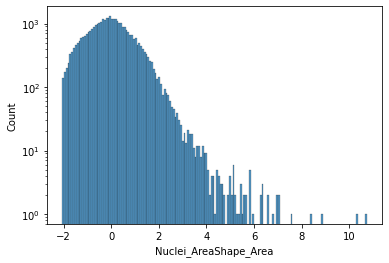

In [208]:
sns.histplot(data=df_cycle, x='Nuclei_AreaShape_Area', log_scale=(False,True))
#sns.histplot(data=df_cycle, x='Nuclei_Intensity_IntegratedIntensity_Hoechst', log_scale=(False,True))

<AxesSubplot:xlabel='Nuclei_Intensity_IntegratedIntensity_Hoechst', ylabel='Nuclei_AreaShape_Area'>

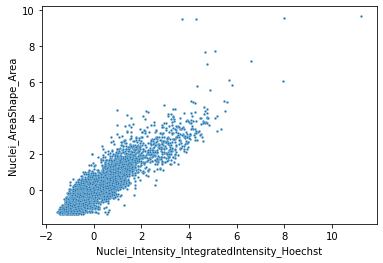

In [190]:
sns.scatterplot(x='Nuclei_Intensity_IntegratedIntensity_Hoechst', y='Nuclei_AreaShape_Area', data=df_cycle, s=6)

In [144]:
mapper = umap.UMAP()
mapper.fit(df_dmso[cycle_cols])

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

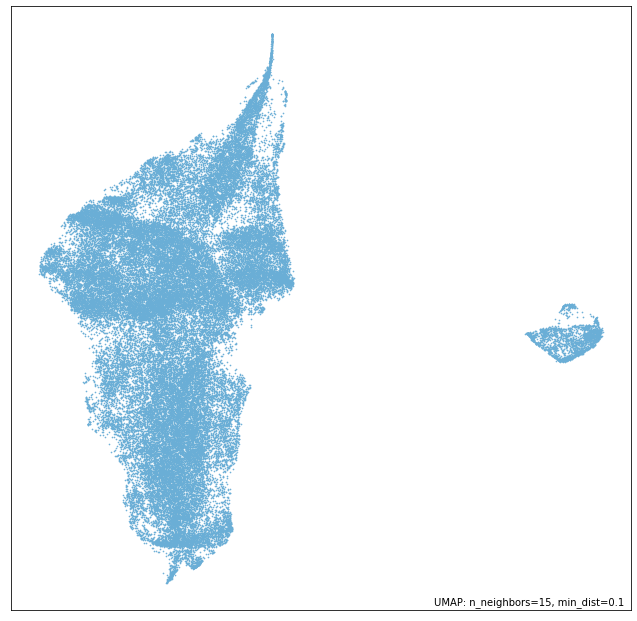

In [145]:
umap.plot.points(mapper)